### Evaluation notebook

Evaluates on `HPatches` dataset.

For an R2D2-like model, given that you have run the inference script `relfm/inference/r2d2_on_hpatches.py` that generates outputs, you can run this notebook to test rotation equivariance of local feature matching.

## Table of Contents

* [Imports](#imports)
* [Configure inputs](#configure_inputs)
* [Generate results](#generate_results)
* [Plot results](#plot_results)

> *Warning*: This notebook takes about 9-10 minutes for generating results per model.

### Imports <a class="anchor" id="imports"></a>

Basic imports.
> Note that you should set `PYTHONPATH=/path/to/repo/:/path/to/repo/lib/r2d2/` before running the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
from os.path import join, exists, expanduser, basename
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.visualize import show_images_with_keypoints, set_latex_fonts, show_grid_of_images
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.inference.r2d2_on_hpatches import configure_save_dir

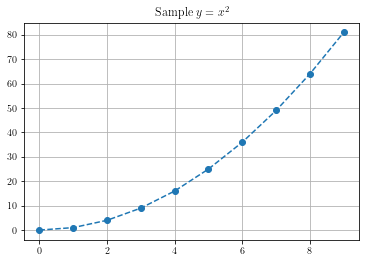

In [3]:
set_latex_fonts(show_sample=True)

### Configure inputs <a class="anchor" id="configure_inputs"></a>

Set the correct data and output paths as well as the model checkpoint that you'd like to evaluate on. Parameters such as `gap_between_rotations` and `imsize` (size of downsized image to evaluate) are hard-coded to be the same as the default values in the inference script.

In [34]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")

model_ckpt_paths = {
    "R2D2": join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt"),
    "R2D2 - $C_{4}$ (Ep 4)": join(REPO_PATH, "trained_models/epoch_16_test_model.pt"),
    # "R2D2 - $SO_{2}$ (Ep 4)": join(REPO_PATH, "trained_models/epoch_3_SO2_4x16_1x32_1x64_2x128.pt"),
    "R2D2 - $C_{8}$ (Ep 4)": join(REPO_PATH, "trained_models/epoch_3_C8_4x16_1x32_1x64_2x128.pt"),
    "R2D2 - $SO_{2}$ (Ep 18)": join(REPO_PATH, "trained_models/epoch_17_SO2_4x16_1x32_1x64_2x128.pt")
}

output_dir = join(expanduser("~"), "outputs/rotation-equivariant-lfm")

In [35]:
assert isdir(data_dir)
assert isdir(output_dir)
# assert exists(model_ckpt_path)

gap_between_rotations=15
downsize=True
imsize=300

ignore_cache = True
overwrite_cache = False

ransac = True
ransac_threshold = 3.

### Generate results <a class="anchor" id="generate_results"></a>

::::::::::::::::::::::::::::::::::::::::::: Generating results for R2D2 for sequence i_greentea ::::::::::::::::::::::::::::::::::::::::::::
Image 4 with rotation 0


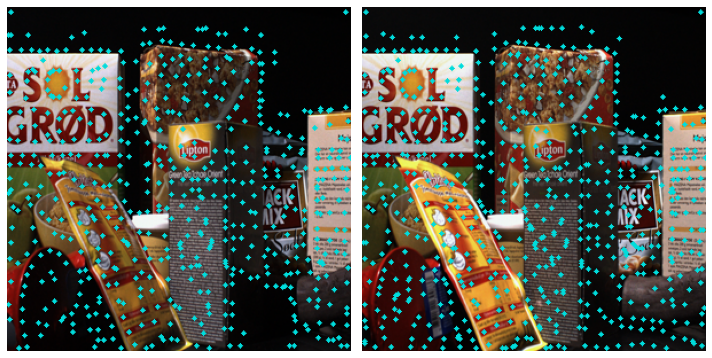

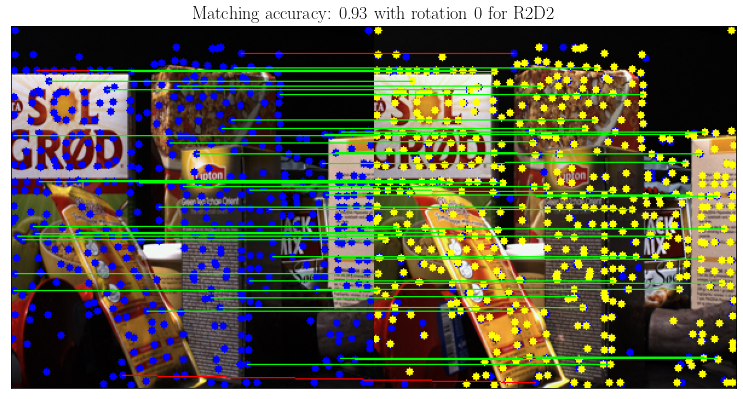

::::::::::::::::::::::::::::::::::: Generating results for R2D2 - $C_{4}$ (Ep 4) for sequence i_greentea :::::::::::::::::::::::::::::::::::
Image 4 with rotation 0


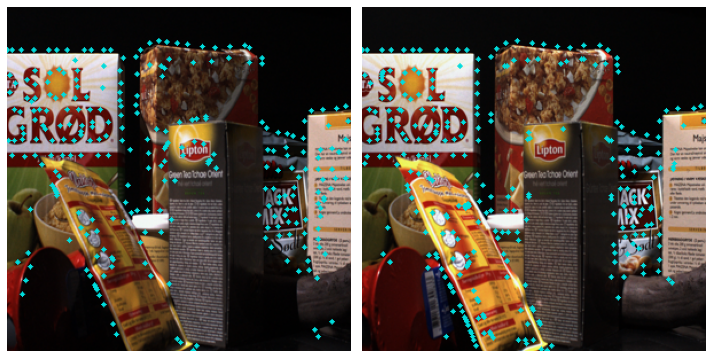

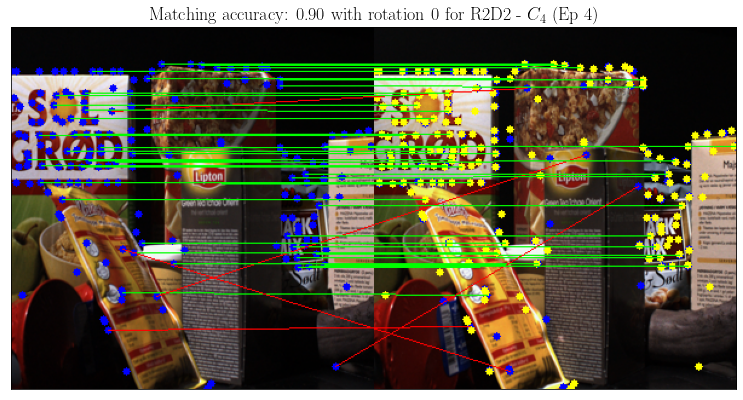

::::::::::::::::::::::::::::::::::: Generating results for R2D2 - $C_{8}$ (Ep 4) for sequence i_greentea :::::::::::::::::::::::::::::::::::
Image 4 with rotation 0


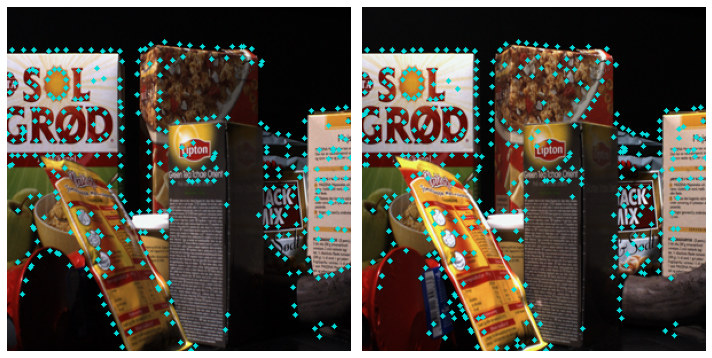

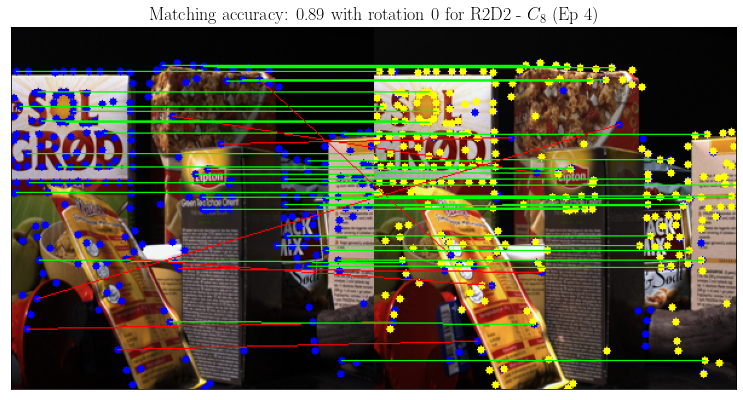

:::::::::::::::::::::::::::::::::: Generating results for R2D2 - $SO_{2}$ (Ep 18) for sequence i_greentea ::::::::::::::::::::::::::::::::::
Image 4 with rotation 0


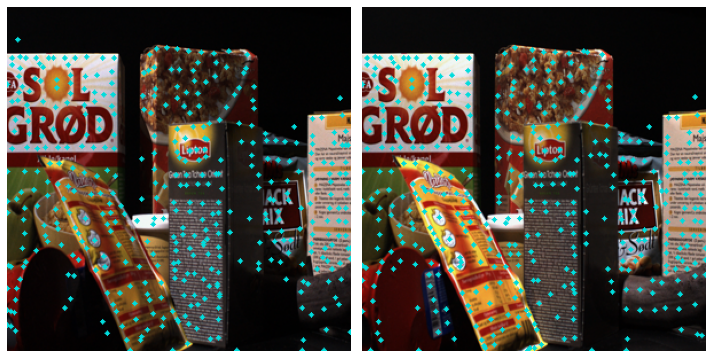

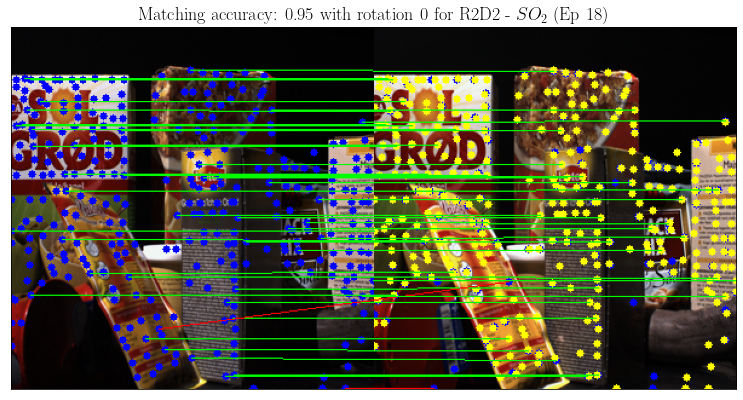

In [60]:
# results = dict()

# load image sequences
sequences = sorted(glob(join(data_dir, "*")))

# # select a random sequence to plot results
# sequence = np.random.choice(sequences)

# choose a sequence to visualize
sequence = sequences[20]

# load rotation values between 0 and 360 degrees
rotations = np.arange(0, 360 + 1, gap_between_rotations, dtype=int)
rotation_to_visualize = 90

# set a (list of) pixel threshold value across which to evaluate rotation robustness
thresholds = [3.]

# set this to true to see intermediate outputs/messages
verbose = True

# select specific target image index to visualize
img2_index = 4
# select specific rotation value to visualize
rotation = 0

target_images_with_kps = dict()

for model_name, model_ckpt_path in model_ckpt_paths.items():

    # save directory
    save_dir = configure_save_dir(output_dir, model_ckpt_path, dataset_name="hpatches")

    print_update(f"Generating results for {model_name} for sequence {basename(sequence)}")

    # set path to the source image
    img1_path = join(sequence, "1.ppm")
    img1 = Image.open(img1_path)
    if downsize:
        img1 = img1.resize((imsize, imsize))

    # load outputs for source image
    sequence_name = os.path.basename(sequence)
    save_path = join(save_dir, sequence_name, "1.npy")
    img1_outputs = np.load(save_path, allow_pickle=True).item()

    # possible indices of the target images
    img2_indices = np.arange(2, 7)

    # load all target images at once
    img2s = [Image.open(join(sequence, f"{i}.ppm")) for i in img2_indices]
    if downsize:
        img2s = [img2.resize((imsize, imsize)) for img2 in img2s]

    # load all homographies
    # NOTE that this is not needed since we save the apt H within outputs itself

    rotation_grid, img2_indices_grid  = np.meshgrid(rotations, img2_indices)
    rotation_grid, img2_indices_grid = rotation_grid.flatten(), img2_indices_grid.flatten()

    # iterator = tqdm_iterator(
    #     range(len(rotation_grid)),
    #     desc=f"Generating qualitative results for {sequence_name} \t:",
    # )
    # for i in iterator:
    #     rotation, img2_index = rotation_grid[i], img2_indices_grid[i]

    if verbose:
        print(f"Image {img2_index} with rotation {rotation}")

    img2 = img2s[img2_index - 2]
    img2_rotated = img2.rotate(rotation)

    save_path = join(save_dir, sequence_name, f"{img2_index}_rotation_{rotation}.npy")
    img2_outputs = np.load(save_path, allow_pickle=True).item()

    # get keypoints and descriptors from the outputs
    kps1 = img1_outputs["keypoints"]
    des1 = img1_outputs["descriptors"]

    kps2 = img2_outputs["keypoints"]
    des2 = img2_outputs["descriptors"]
    H = img2_outputs["H"]

    # show detected keypoints
    if verbose:
        images_with_kps = show_images_with_keypoints([img1, img2_rotated], [kps1, kps2], radius=2, return_images=True)
        target_images_with_kps[model_name] = images_with_kps[-1]

    # perform matching
    width, height = img2.size
    result = evaluate_matching_with_rotation(
        kp1=kps1,
        des1=des1,
        kp2=kps2,
        des2=des2,
        H=H,
        width=width,
        height=height,
        rotation=rotation,
        return_metadata=True,
        threshold=3.,
    )

    # show matching results
    if verbose:
        analyze_result(img1, img2_rotated, result, K=50, radius=3, model_name=model_name, save_dir="../Figures/")

### Show keypoint detection in target images

In [61]:
len(target_images_with_kps)

4

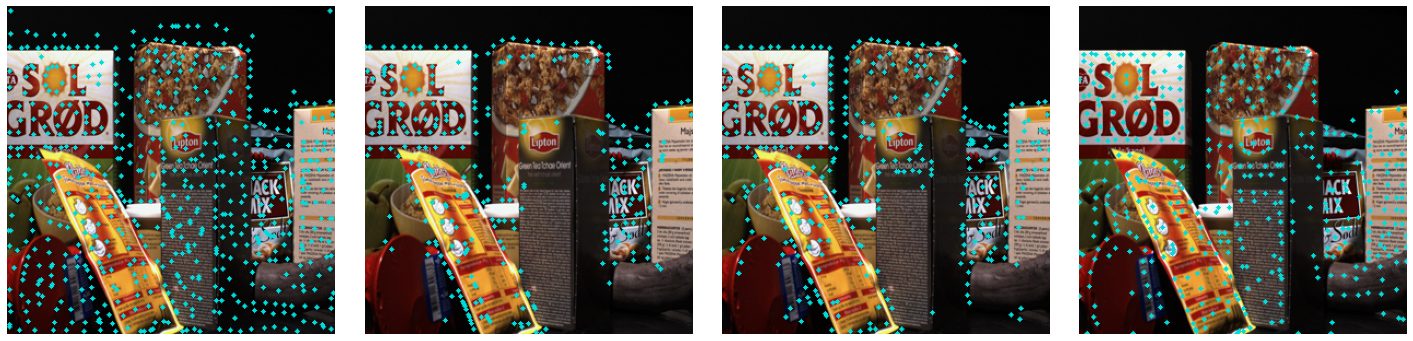

In [62]:
images = list(target_images_with_kps.values())
subtitles = list(target_images_with_kps.keys())
subtitles = [x.split("(")[0] for x in subtitles]

use_titles = False
if not use_titles:
    subtitles = None

show_grid_of_images(
    images,
    n_cols=4, figsize=(20, 5),
    subtitles=subtitles,
    subtitlesize=20,
)